## NetREX+ on yeast data with changes to C matrix

In [206]:
#NETREX
#needed for package

import numpy as np
import pandas as pd
import sys
from implicit import als
import math
import cvxopt
from scipy.linalg import fractional_matrix_power, block_diag
from pylab import *
from cvxpy import *
import argparse
import mosek
from scipy.sparse import csr_matrix
import copy


#testing
import warnings
#netrex

class NetREX: 
    #init
    def __init__(self, E, C, lambda_, theta=1, alpha=10, iternum = 3000, p = 30, solver = ECOS):
        #parameters
        self.theta = theta # scalar > 0
        self.alpha = alpha
        self.xbound = 1.0
        self.ybound = 1.0
        self.iternum = iternum
        self.lambda_ = lambda_ #parameter matrix
        #read in exp, read prior data 
        #self.ReadExp(ExpFile) #get ExpMat from this
        self.ExpMat = E #expression for now
        self.C = C #matrix of confidences (weights)
        self.NumGene = E.shape[0]
        self.NumTF = C.shape[1]
        self.NumExp = E.shape[1]
        #parameter matrix eta
        self.eta = self.C + theta
        self.i_ = range(self.NumGene) #range of i
        self.j_ = range(self.NumTF) #range of j 
        #controls amount of factors in xi/yj
        self.p = p
        #set solver
        self.solver = solver
        
    #Put read in exp here later
    
    #initialization
    def initialization(self):
        #!!! other parameters!!!
        #Use implicit package for CF problems to initialize X & Y: 
        implicit_model = als.AlternatingLeastSquares(factors=self.p)
        #take cutoff of C and add to get new weight matrix
        #C_cutoff = np.where(self.C > 0.1, (1 + 2*self.C), 0)
        #print(np.where(~C_cutoff.any(axis=1))[0])
        
        #^Cutoff is creating rows of all 0s in C. Try without cutoff
        
        #train model on weight matrix
        #implicit_model.fit(csr_matrix(C_cutoff))
        implicit_model.fit(csr_matrix(self.C))
        #initial X (matrix of xi vectors)
        self.X = implicit_model.item_factors.T
        for i in self.i_:
            TmpNorm = np.linalg.norm(self.X[:,i])
            if TmpNorm < 1E-5:
                continue
            self.X[:,i] = self.X[:,i] / TmpNorm
        np.nan_to_num(self.X, copy=False)
        #initial Y (matrix of yj vectors)
        self.Y = implicit_model.user_factors.T
        for j in self.j_:
            TmpNorm = np.linalg.norm(self.Y[:,j])
            if TmpNorm < 1E-5:
                continue
            self.Y[:,j] = self.Y[:,j] / TmpNorm
        np.nan_to_num(self.Y, copy=False)
        
        #set initial S to C
        #self.S = copy.deepcopy(self.C)
        #binarize S to use for finding A 
        #S_init = (self.S > 0).astype(int)
        #initialize A using NetREX 1 closed form
        #!!!!!Other options!!!!!
        #Abound = 1.0
        #self.A = np.linalg.inv(S_init.T.dot(S_init)+np.eye(self.NumTF)).dot(S_init.T).dot(self.ExpMat)
        #self.A = np.multiply((np.absolute(Atmp)<=Abound), Atmp) + \
                                       # np.multiply((np.absolute(Atmp)>Abound), np.sign(Atmp)*Abound)
        
        #try using NCA to get initial A
        self.A = self.NCA_()
        
        #initial Uk
        mu_S = np.linalg.norm(self.A.dot(self.A.T), 'fro')
        Uk = self.S - (2./mu_S)*(self.S.dot(self.A).dot(self.A.T) - self.ExpMat.dot(self.A.T))
        #initial S 
        c = np.sqrt((2./mu_S)*(self.alpha*self.lambda_*np.square(np.ones([self.NumGene,self.NumTF]) -
                                                          self.X.T.dot(self.Y)) + self.eta))  
        Sequal = np.where(np.absolute(Uk) == c, c*np.random.randint(2, size=(self.NumGene,self.NumTF)), 0)
        Sgreater = np.where(np.absolute(Uk) > c, Uk, 0)
        self.S = Sequal + Sgreater
        
        plt.figure(1, figsize=(8, 8))
        ax1 = plt.subplot(211)
        ax1.imshow(self.S)
        ax2 = plt.subplot(212)
        ax2.imshow(self.X.T.dot(self.Y))
        plt.show() 
    
    #try to program iterative NCA
    def NCA_(self):
        #set initial S to C
        self.S = copy.deepcopy(self.C)
        #binarize S to use for finding A 
        S_init = (self.S > 0).astype(int).astype(float)
        for k in range(50):
            A_init = np.linalg.inv(S_init.T.dot(S_init)+ 0.1*np.eye(self.NumTF)).dot(S_init.T).dot(self.ExpMat)
            # update S
            for i in range(self.NumGene):
                Indn0 = np.where(self.S[i,:]!=0)[0]
                Et = self.ExpMat[i,:]
                At = A_init[Indn0,:]
                St = Et.dot(At.T).dot(np.linalg.inv(At.dot(At.T)+0.1*np.eye(At.shape[0])))
                S_init[i,Indn0] = St 
            
        return A_init
        
    #Define the objective function 
    def ObjFunction(self):
        S_0 = (self.S != 0).astype(int) 
        self.a_ = self.lambda_*(self.C + self.alpha*S_0)
        W = np.sqrt(self.a_) 
        Val = np.linalg.norm(self.ExpMat - self.S.dot(self.A), 'fro')**2 +np.linalg.norm(W*(S_0 - self.X.T.dot(self.Y)),
                    'fro')**2 + np.linalg.norm(np.sqrt(self.eta*S_0), 'fro')**2
        return Val
    
    def PALM_A(self):
        mu_A = np.linalg.norm(self.S.T.dot(self.S), 'fro')
        #solution for A
        self.A = (np.linalg.inv((2./mu_A)*self.S.T.dot(self.S)+ np.identity(self.NumTF))).dot(((2./mu_A) * 
                                                                self.ExpMat.T.dot(self.S) + self.A.T).T) 
        
    def PALM_S(self):
        mu_S = np.linalg.norm(self.A.dot(self.A.T), 'fro')
        Uk = self.S - (2./mu_S)*(self.S.dot(self.A).dot(self.A.T) - self.ExpMat.dot(self.A.T))
        c = np.sqrt((2./mu_S)*(self.alpha*self.lambda_*np.square(np.ones([self.NumGene,self.NumTF]) -
                                                          self.X.T.dot(self.Y)) + self.eta))
        '''
        plt.figure(1, figsize=(8, 3))
        ax1 = plt.subplot(211)
        ax1.imshow(c)
        ax2 = plt.subplot(212)
        ax2.imshow(Uk)
        plt.show() 
        
        print(c[30:, 0:20])
        print(Uk[30:, 0:20])
        '''
        
        #solution for S   
        Sequal = np.where(np.absolute(Uk) == c, c*np.random.randint(2, size=(self.NumGene,self.NumTF)), 0)
        Sgreater = np.where(np.absolute(Uk) > c, Uk, 0)
        self.S = Sequal + Sgreater
        #print(self.S)
        self.S_0 = (self.S != 0).astype(int)
    
    def solve_qcqp(self, phi, varphi): 
        '''
        Use cvxpy to solve the problem: 
        min x^T*phi*x + varphi*x
        s.t. to norm(x) <= 1
        (problem is the same for y)
        '''
        x = Variable(self.p)
        P = (phi/10.).astype(np.double) #this is phi modified for cvxpy
        q = (varphi/10.).astype(np.double) #varphi modified for cvxpy
        
        #print(P, q)
        objective = Minimize(quad_form(x,P) - q.T*x)
        constraints = [square(norm(x)) <= 1]
        
        prob = Problem(objective, constraints)
        
        try:
            result = prob.solve(solver=self.solver)
            return x.value
        except:
            print(P, q)
            prob.solve(verbose=True)
            
            
           
    def PALM_x(self):
        #define variables for matrix formulation
        for i in self.i_: 
            x = self.X[:,i]
            S_0 = (self.S != 0).astype(int)
            a_ = self.lambda_*(self.C + self.alpha*S_0)
            A_i = np.diag([a_[i,j] for j in self.j_])
            S_i = np.array([S_0[i,j] for j in self.j_]) 
            mu_x = np.linalg.norm(2*self.Y.dot(A_i).dot(self.Y.T), 'fro')                            
            phi = (mu_x/2)*np.identity(self.p) + self.Y.dot(A_i).dot(self.Y.T)
            varphi = 2*S_i.dot(A_i).dot(self.Y.T) + mu_x*x.T 
            self.X[:,i] = self.solve_qcqp(phi, varphi)
        
    def PALM_y(self):
        #matrix formulation
        for j in self.j_:
            y = self.Y[:,j]
            S_0 = (self.S != 0).astype(int)
            a_ = self.lambda_*(self.C + self.alpha*S_0)
            A_j = np.diag([a_[i,j] for i in self.i_])
            S_j = np.array([S_0[i,j] for i in self.i_])
            mu_y = np.linalg.norm(2*self.X.dot(A_j).dot(self.X.T), 'fro')
            phi = (mu_y/2)*np.identity(self.p) + self.X.dot(A_j).dot(self.X.T)
            varphi = 2*S_j.T.dot(A_j).dot(self.X.T) + mu_y*y.T
            #print(np.ptp(self.X.dot(A_j).dot(self.X.T)))
            #print(np.ptp(phi), np.ptp(varphi))
            #print(j, np.ptp(2*S_j.T.dot(A_j).dot(self.X.T)))
            #print(j, np.amax(y.T), np.amin(y.T))
            #print(j, mu_y)
            self.Y[:,j] = self.solve_qcqp(phi, varphi)
            
    #algorithm
    def NetREX_algorithm(self):
        self.initialization()
        conv_point = 10 #for now?  

        Valold = self.ObjFunction()
        for k in range(self.iternum): 
            self.PALM_A()
            
            '''
            plt.figure(1, figsize=(40, 30))
            ax1 = plt.subplot(211)
            ax1.imshow(self.A)
            plt.show()
            
            plt.figure(1, figsize=(40, 30))
            ax1 = plt.subplot(211)
            n, bins, patches = plt.hist(self.A.flatten(), 50, density=True, facecolor='g', alpha=0.75)
            plt.show()
            
            
            print(np.amin(self.A))
            '''
            
            self.PALM_S()
            self.PALM_x()
            self.PALM_y()
            
            '''plt.figure(1, figsize=(40, 30))
            ax1 = plt.subplot(211)
            ax1.imshow(self.S)
            ax2 = plt.subplot(212)
            ax2.imshow(self.X.T.dot(self.Y))
            plt.show() '''
        
            Valnew = self.ObjFunction()
            print("Itr %d, Obj %f" % (k, Valnew))
            check_pt = np.abs(Valold-Valnew)
            if (check_pt < conv_point) :
                print("Converge!")
                sys.stdout.flush()
                break
            Valold = Valnew
        return Valold
        
def main():
        #parser = argparse.ArgumentParser(description='netREX: network rewiring using expression')
        #define arguments
        #requiredArgs = parser.add_argument_group('required arguments')
        #requiredArgs.add_argument('-e', type=str, nargs=1, dest='expfile', required=True, metavar="expression_file",
        #                     default=None, help="<Required> Name of the expression file")
        #requiredArgs.add_argument('-c', type=str, nargs=1, dest='confidences', required=True, 
        #                metavar="confidence_matrix", default=None, help='<Required> File w matrix of confidences')
        #parser.add_argument()
    
        #parse arguments from std input
        #args=parser.parse_args()
    
        #if len(sys.argv)==1:
        #    parser.print_help(sys.stderr)
        #    sys.exit(1)
    
        #if args.expfile == None:
        #    sys.exit('missing expression data file!')
        
        #if args.confidences == None:
        #    sys.exit('missing confidence file!')
    
        #run netrex
        #tmp = NetREX(E_real, C_test, lmda_real)
        #tmp.NetREX_algorithm()
        print("Ready")
        #warnings.simplefilter('error', RuntimeWarning)

if __name__ == '__main__':
    main()

Ready


In [159]:
#get combined expression datasets


natvar = pd.read_table('../../s2cell-prior/data/yeast_networks/expression/NatVar.txt', index_col=0)
stress = pd.read_table('../../s2cell-prior/data/yeast_networks/expression/Stress.txt', index_col=0)
common_genes = natvar.index.intersection(stress.index)
combined = natvar.loc[common_genes].join(stress.loc[common_genes])

In [160]:
#get combined prior datasets

chip = pd.read_table('../../s2cell-prior/data/yeast_networks/priors/ChIP_prior.txt', header=None,
                    names=['regulator','gene', 'weight'])
motif = pd.read_table('../../s2cell-prior/data/yeast_networks/priors/Motif_prior.txt', header=None,
                    names=['regulator','gene', 'weight'])

In [161]:
print(chip.shape, motif.shape)

(245784, 3) (202926, 3)


In [162]:
chip = chip.set_index(['gene','regulator']).unstack().fillna(value=0)
#remove names
chip.columns = chip.columns.get_level_values(1)
chip.index.name = None
chip.columns.name = None

chip.head()

,MATA1,TBP,YAL011W,YAL021C,YAL043C,YAL051W,YBL002W,YBL005W,YBL008W,YBL021C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
YAL001C,0.0,0.295455,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.529278,0.0,0.000000,0.0,0.0
YAL002W,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.335520,0.0,0.0,0.552461,0.0,0.000000,0.0,0.914234,0.0,0.0
YAL003W,0.0,0.000000,0.0,0.309524,0.0,0.0,0.0,0.0,0.0,0.0,...,0.981256,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
YAL004W,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
YAL005C,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.794283,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


In [163]:
motif = motif.set_index(['gene','regulator']).unstack().fillna(value=0)
#remove names
motif.columns = motif.columns.get_level_values(1)
motif.index.name = None
motif.columns.name = None

motif.head()

,MAL63,MATA1-MATALPHA2-DIMER,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL051W,YBL005W,YBL054W,YBL103C,YBR033W,...,YPR013C,YPR015C,YPR022C,YPR052C,YPR054W,YPR065W,YPR086W,YPR104C,YPR196W,YPR199C
Q0045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977


In [164]:
bothprior = chip.add(motif, fill_value=0)

In [165]:
bothprior.head()

,MAL63,MATA1,MATA1-MATALPHA2-DIMER,TBP,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL011W,YAL021C,YAL043C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
Q0045,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977
Q0050,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977
Q0055,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977
Q0060,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977
Q0065,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977


In [166]:
bothprior.fillna(value=0, inplace=True)

In [167]:
bothprior.head()

,MAL63,MATA1,MATA1-MATALPHA2-DIMER,TBP,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL011W,YAL021C,YAL043C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
Q0045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977
Q0050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977
Q0055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977
Q0060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977
Q0065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977


In [168]:
bothprior.shape

(6186, 387)

In [169]:
#once i have expression i can get intersection and reindex
good_idx = combined.index.intersection(bothprior.index)
idx_exp = combined.loc[good_idx]
idx_prior = bothprior.loc[good_idx]
idx_prior.head()

,MAL63,MATA1,MATA1-MATALPHA2-DIMER,TBP,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL011W,YAL021C,YAL043C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
YAL008W,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.000000,...,0.000000,0.0,0.50,0.663062,0.0,0.194613,0.0,0.0,0.000000,0.0
YBR255W,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.90806,0.0,0.016632,...,0.000000,0.0,0.00,0.474741,0.0,0.344844,0.0,0.0,0.000000,0.0
YGR131W,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.000000,...,0.153495,0.0,0.50,0.000000,0.0,0.068175,0.0,0.0,0.000000,0.0
YPL144W,0.0,0.0,0.0,0.113636,0.0,0.51606,0.0,0.00000,0.0,0.000000,...,0.942830,0.0,1.06,0.000000,0.0,0.714667,0.0,0.0,0.012371,0.0
YBR135W,0.0,0.0,0.0,0.143836,0.0,0.00000,0.0,0.00000,0.0,0.000000,...,1.077155,0.0,0.50,0.000000,0.0,0.557300,0.0,0.0,0.000000,0.0


In [170]:
print(np.amin(idx_prior.values), np.amax(idx_prior.values))

0.0 3.65296


In [171]:
3.65 * 0.20

0.73

In [172]:
#Cutoff C


prior_cutoff = pd.DataFrame(np.where(idx_prior.values > 0.7, idx_prior.values, 0), index=idx_prior.index, 
             columns=idx_prior.columns)

#check how many all 0 columns? 
prior_cutoff.loc[:, (prior_cutoff == 0).all(axis=0)].shape

(5529, 4)

In [173]:
np.amax(idx_prior[zero_columns].values)

0.5

In [174]:
0.667 * 0.05

0.033350000000000005

In [175]:
zero_columns = prior_cutoff.loc[:, (prior_cutoff == 0).all(axis=0)].columns

zero_column_filters = pd.DataFrame(np.where(idx_prior[zero_columns] > 0.03, idx_prior[zero_columns], 0), 
             index=idx_prior[zero_columns].index, columns=idx_prior[zero_columns].columns)

prior_cutoff[zero_columns] = zero_column_filters

In [176]:
prior_cutoff.loc[:, (prior_cutoff == 0).all(axis=0)].shape

(5529, 0)

In [177]:
prior_cutoff.loc[:, (prior_cutoff != 0).any(axis=0)].shape

(5529, 387)

In [178]:
prior_cutoff.loc[(prior_cutoff != 0).any(axis=1), :].shape

(5491, 387)

In [179]:
zero_rows = prior_cutoff.loc[(prior_cutoff == 0).all(axis=1), :].index

np.amax(idx_prior.loc[zero_rows].values)

0.6984130000000001

In [180]:
zero_row_filters = pd.DataFrame(np.where(idx_prior.loc[zero_rows] > 0.03, idx_prior.loc[zero_rows], 0), 
             index=idx_prior.loc[zero_rows].index, columns=idx_prior.loc[zero_rows].columns)

prior_cutoff.loc[zero_rows] = zero_row_filters

In [185]:
prior_cutoff = prior_cutoff.loc[(prior_cutoff != 0).any(axis=1), :]

In [186]:
#cant get rid of two all zero rows so reindexing again -_____-

reindex = prior_cutoff.index.intersection(idx_exp.index)
idx_exp2 = idx_exp.loc[reindex]
idx_prior2 = prior_cutoff.loc[reindex]

In [187]:
e_yeast_2 = idx_exp2.values
c_yeast_2 = idx_prior2.values
lmbda = np.ones((c_yeast_2.shape[0], c_yeast_2.shape[1]))

In [188]:
print(e_yeast_2.shape, c_yeast_2.shape)

(5527, 550) (5527, 387)


100%|██████████| 15.0/15 [00:15<00:00,  1.03s/it]


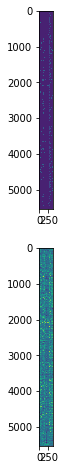

Itr 0, Obj 3622984.532510
Itr 1, Obj 2994809.822444
Itr 2, Obj 2624612.408170
Itr 3, Obj 2376321.911449
Itr 4, Obj 2201871.750436
Itr 5, Obj 2073740.192852
Itr 6, Obj 1975674.562342
Itr 7, Obj 1898032.756760
Itr 8, Obj 1834806.132565
Itr 9, Obj 1782015.776835
Itr 10, Obj 1737129.020620
Itr 11, Obj 1698332.303753
Itr 12, Obj 1664322.012439
Itr 13, Obj 1634249.681353
Itr 14, Obj 1607341.027865
Itr 15, Obj 1583153.619596
Itr 16, Obj 1561154.642928
Itr 17, Obj 1541128.587714
Itr 18, Obj 1522731.699338
Itr 19, Obj 1505753.432397
Itr 20, Obj 1490100.882982
Itr 21, Obj 1475528.790988
Itr 22, Obj 1461949.769424
Itr 23, Obj 1449234.383194
Itr 24, Obj 1437330.397428
Itr 25, Obj 1426128.773526
Itr 26, Obj 1415592.369083
Itr 27, Obj 1405620.259333
Itr 28, Obj 1396204.504289
Itr 29, Obj 1387288.947439
Itr 30, Obj 1378820.056831
Itr 31, Obj 1370801.770737
Itr 32, Obj 1363152.061897
Itr 33, Obj 1355806.282675
Itr 34, Obj 1348802.614504
Itr 35, Obj 1342089.154470
Itr 36, Obj 1335648.780848
Itr 37, Obj

Itr 297, Obj 1006344.791328
Itr 298, Obj 1005949.438973
Itr 299, Obj 1005558.403792
Itr 300, Obj 1005175.869911
Itr 301, Obj 1004788.803063
Itr 302, Obj 1004406.676700
Itr 303, Obj 1004018.530706
Itr 304, Obj 1003633.365844
Itr 305, Obj 1003252.306907
Itr 306, Obj 1002870.062274
Itr 307, Obj 1002489.336307
Itr 308, Obj 1002101.970089
Itr 309, Obj 1001733.716128
Itr 310, Obj 1001367.463900
Itr 311, Obj 1000997.090722
Itr 312, Obj 1000630.694802
Itr 313, Obj 1000262.614464
Itr 314, Obj 999902.420682
Itr 315, Obj 999531.786390
Itr 316, Obj 999179.248526
Itr 317, Obj 998821.228415
Itr 318, Obj 998460.787327
Itr 319, Obj 998093.458818
Itr 320, Obj 997741.279418
Itr 321, Obj 997373.937737
Itr 322, Obj 997021.844686
Itr 323, Obj 996680.024552
Itr 324, Obj 996323.039230
Itr 325, Obj 995969.205111
Itr 326, Obj 995616.130892
Itr 327, Obj 995261.946186
Itr 328, Obj 994906.771109
Itr 329, Obj 994558.100410
Itr 330, Obj 994212.702323
Itr 331, Obj 993864.427411
Itr 332, Obj 993512.616207
Itr 333, Ob

[[35.04197167  0.15879577  0.80564029  0.8585724   0.9029805   0.95412477
   0.95316873  0.81479334  0.66774326  1.12328813  1.0483285   1.08581247
   0.82520154  0.51200715  0.50177008  1.30039526  0.26705518  0.26108217
   0.80770819  0.52460666  0.91847113  0.72908278  0.86326884  1.00304564
   1.06602743  0.68429257  0.82600726  0.52002074  1.33775336  0.87235048]
 [ 0.15879577 34.46501031  0.20628364  0.22002556  0.23132544  0.24293866
   0.24331743  0.2084819   0.16999613  0.28670483  0.26725279  0.27652807
   0.21011592  0.13087278  0.12880487  0.33161219  0.07032486  0.0663101
   0.20692981  0.13437842  0.23425571  0.18632656  0.21989411  0.25519457
   0.27267693  0.17607243  0.21161615  0.13214627  0.34157077  0.22243121]
 [ 0.80564029  0.20628364 35.4745732   1.11955892  1.17689615  1.24433607
   1.242467    1.06200946  0.87139999  1.46411148  1.36703615  1.41655485
   1.07579315  0.66787367  0.65439276  1.69570652  0.34788319  0.34109904
   1.05208175  0.68463466  1.19771257

KeyboardInterrupt: 

In [189]:
yeast_c_cutoff = NetREX(e_yeast_2, c_yeast_2, lmbda)
yeast_c_cutoff.NetREX_algorithm()

In [201]:
predicted = pd.DataFrame(yeast_c_cutoff.S, index=idx_prior2.index, columns=idx_prior2.columns)
predicted.head()

,MAL63,MATA1,MATA1-MATALPHA2-DIMER,TBP,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL011W,YAL021C,YAL043C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
YAL008W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.265772,0.0,...,0.000000,0.0,-0.207050,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
YBR255W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.782973,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
YGR131W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.175165,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
YPL144W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.825156,0.0,0.514129,0.0,0.0,0.443183,0.0,0.0,0.0,0.196085
YBR135W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,1.247814,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [209]:
predicted.to_csv('yeast_netrex_c_cutoff_predicted_network', sep='\t')